# Project Part b)

In [2]:
from fenics import *
from dolfin import *
from mshr import *

import matplotlib
#%matplotlib qt
#%matplotlib widget
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 10
from matplotlib import cm

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=300)
from scipy import sparse
import scipy.sparse.linalg as splinalg


from mpl_toolkits.mplot3d import Axes3D

In [3]:
def assembler(p, e, t, f):
    n_p = np.shape(p)[0]       # number of nodes
    n_t = np.shape(t)[0]       # number of elements
    n_e = np.shape(e)[0]       # number of boundary edges
    A = sparse.lil_matrix((n_p, n_p))   # allocate stiffnessmatrix
    b = np.zeros(n_p)          # load vector
    
    for K in np.arange(n_t):
        loc2glb = t[K]
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        area, bi, ci = HatGradients(x, y)
        AK = (np.outer(bi,bi) + np.outer(ci,ci))*area
        bK = np.array([f(x[0], y[0]),
                       f(x[1], y[1]),
                       f(x[2], y[2])])/3*area
        A[np.ix_(loc2glb, loc2glb)] += AK
        b[np.ix_(loc2glb)] += bK
     
    return A, b

    
def polyArea(x, y):
    v1 = np.array([x[1]-x[0], y[1]-y[0]])
    v2 = np.array([x[2]-x[0], y[2]-y[0]])
    area = 1/2 * np.linalg.norm(np.cross(v1, v2))
    return area


def HatGradients(x, y):
    ''' Returns the area, b, and c
        Grad(ph_i) = transpose([b_i, c_i])
    '''
    area = polyArea(x, y);
    b = np.array([y[1]-y[2], y[2]-y[0], y[0]-y[1]])/2/area
    c = np.array([x[2]-x[1], x[0]-x[2], x[1]-x[0]])/2/area
    return area, b, c

In [4]:
domain = Circle(Point(0.,0.),1.0,60)
mesh = generate_mesh(domain, 40, "cgal")
#plot(mesh)
#plt.show()

p = mesh.coordinates()

# Constructing the e array. For each edge: (start_index, end_index)
e_points = BoundaryMesh(mesh, "exterior", True)
e_indices = e_points.entity_map(0)
e = e_indices.array()
e2 = np.append(e[1:], e[0])
e = np.dstack((e, e2)).squeeze()

t = mesh.cells()

# Problem B.1

In [5]:
def f(x, y):    
    '''Force applied at given cooridinates (x,y)'''
    return 8 * np.pi**2 * np.sin(2*np.pi*x) * np.sin(2*np.pi*y)

def u_exact(x, y):
    '''Dirichlet boundary condition'''
    return np.sin(2*pi*x) * np.sin(2*pi*y)

I = np.eye(len(p))
A, b = assembler(p, e, t, f)
A[e[:,0],:] = I[e[:,0],:]
x = p[:,0]
y = p[:,1]
b[e[:,0]] = u_exact(x[e[:,0]], y[e[:,0]])

u = splinalg.spsolve(A.tocsr(), b)

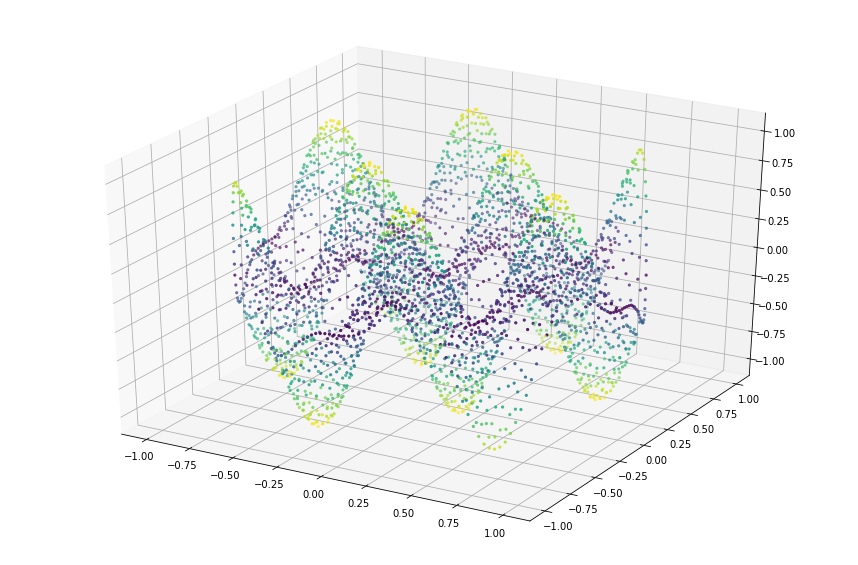

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
c = np.abs(u)
cmvir = plt.get_cmap("viridis")
ax.scatter(x, y, u, s=5, c=c, cmap=cmvir)
plt.show()

# Problem B.2

# Problem B.3